In [1]:
from tictactoe_env import TicTacToe
from tictactoe_debug import TicTacToeGame, QLearningPlayer, RandomPlayer, Trainer, DQNPlayer
import numpy as np
from tqdm.notebook import tqdm
from collections import defaultdict
from itertools import product
import torch

%load_ext autoreload
%autoreload 2

In [2]:
env = TicTacToe()
game = TicTacToeGame(env)
rplayer_x = RandomPlayer()
rplayer_o = RandomPlayer()

game.check_rewards(rplayer_x, rplayer_o, n_iter=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

{'wins_x': 5892, 'wins_o': 2846, 'draws': 1262, 'missx': 0, 'misso': 0}

In [6]:
trainer = Trainer(game)

## 3x3

In [21]:
qplayer_params = {'eps': 0.3, 'alpha': 0.01, 'gamma': 1}
qplayer_x , qplayer_o = QLearningPlayer(**qplayer_params), QLearningPlayer(**qplayer_params)

In [9]:
trainer.train_one('x', qplayer_x, n_iter=100000)
trainer.train_one('o', qplayer_o, n_iter=100000)

Training QLearningPlayer(eps=0.3, alpha=0.01, gamma=1):   0%|          | 0/100000 [00:00<?, ?it/s]

Training QLearningPlayer(eps=0.3, alpha=0.01, gamma=1):   0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

{'wins_x': 10000, 'wins_o': 0, 'draws': 0, 'missx': 0, 'misso': 0}

In [14]:
game.check_rewards(qplayer_x, qplayer_o)

  0%|          | 0/10000 [00:00<?, ?it/s]

{'wins_x': 10000, 'wins_o': 0, 'draws': 0, 'missx': 0, 'misso': 0}

In [15]:
qplayer_x.reset()
trainer.train_two(qplayer_x, qplayer_o, n_iter=100000)
game.check_rewards(qplayer_x, rplayer_o)

Training x: QLearningPlayer(eps=0.3, alpha=0.01, gamma=1) vs o: QLearningPlayer(eps=0.3, alpha=0.01, gamma=1):…

  0%|          | 0/10000 [00:00<?, ?it/s]

{'wins_x': 7864, 'wins_o': 0, 'draws': 144, 'missx': 1992, 'misso': 0}

Wins percentage: 0.6252
Wins percentage: 0.6526
Wins percentage: 0.7595
Wins percentage: 0.8293
Wins percentage: 0.8878
Wins percentage: 0.9059
Wins percentage: 0.9135
Wins percentage: 0.926
Wins percentage: 0.9417
Wins percentage: 0.9459
Wins percentage: 0.9541
Wins percentage: 0.9547
Wins percentage: 0.9465
Wins percentage: 0.9451
Wins percentage: 0.9546
Wins percentage: 0.9515
Wins percentage: 0.9545
Wins percentage: 0.9514
Wins percentage: 0.9559
Wins percentage: 0.9539
Wins percentage: 0.9585
Wins percentage: 0.9607
Wins percentage: 0.9597
Wins percentage: 0.9603
Wins percentage: 0.9612
Wins percentage: 0.9613
Wins percentage: 0.957
Wins percentage: 0.9614
Wins percentage: 0.9577
Wins percentage: 0.9554
Wins percentage: 0.9583
Wins percentage: 0.9598
Wins percentage: 0.9636
Wins percentage: 0.9586
Wins percentage: 0.9581
Wins percentage: 0.9556
Wins percentage: 0.9624
Wins percentage: 0.9615
Wins percentage: 0.9601
Wins percentage: 0.9605


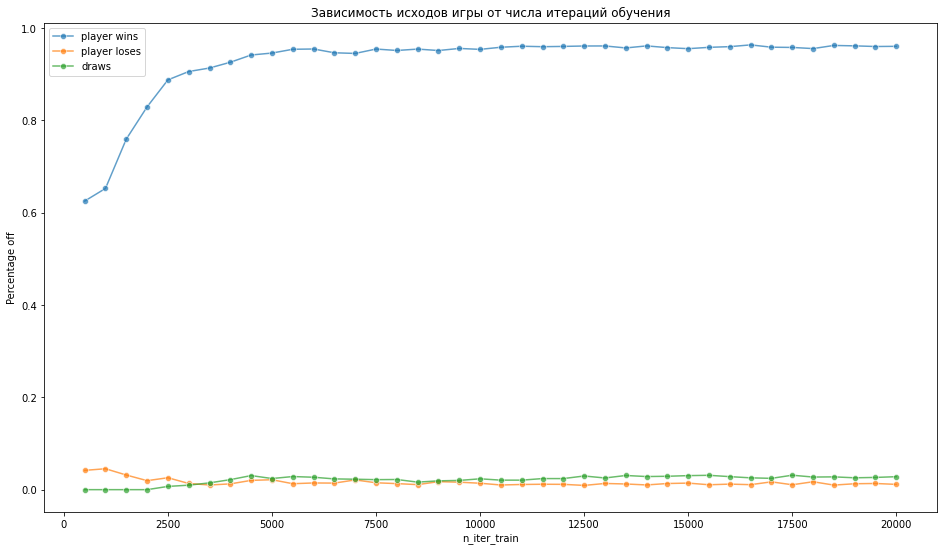

In [25]:
trainer.plot_learning_one('x', qplayer_x, rplayer_o, max_iter=20000, iter_step=500, iter_check=10000)

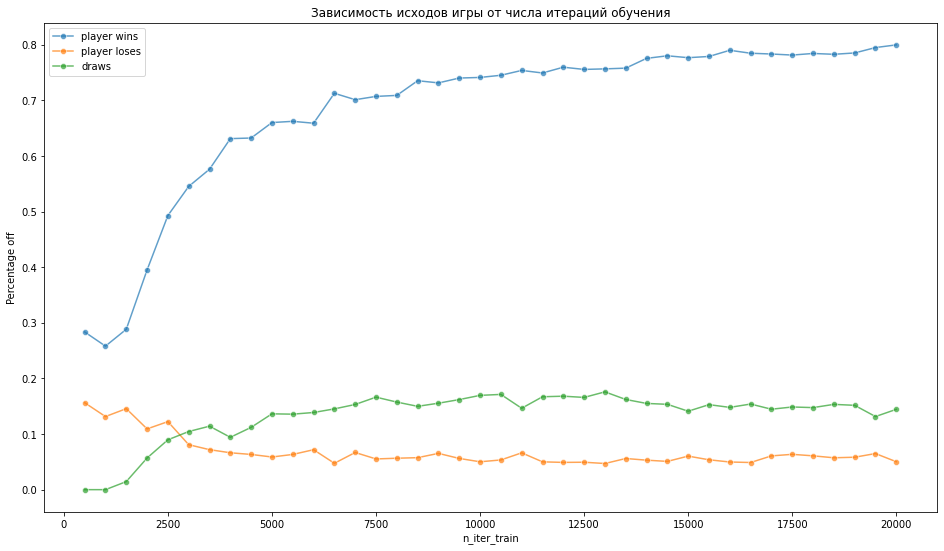

In [26]:
trainer.plot_learning_one('o', qplayer_o, rplayer_x, max_iter=20000, iter_step=500, iter_check=10000)

## 4x4

In [100]:
env = TicTacToe(4, 4)
game = TicTacToeGame(env)

In [101]:
qplayer_params = {'eps': 0.3, 'alpha': 0.01, 'gamma': 1, 'n_rows': 4, 'n_cols': 4}
qplayer_x , qplayer_o = QLearningPlayer(**qplayer_params), QLearningPlayer(**qplayer_params)
rplayer_x, rplayer_o = RandomPlayer(), RandomPlayer()

In [102]:
trainer = Trainer(game)
trainer.train_one('x', qplayer_x, sparring_partner=rplayer_o, n_iter=100000)
game.check_rewards(qplayer_x, rplayer_o)

Training QLearningPlayer(eps=0.3, alpha=0.01, gamma=1):   0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

{'wins_x': 9604, 'wins_o': 34, 'draws': 0, 'missx': 362, 'misso': 0}

In [103]:
trainer.train_one('o', qplayer_o, sparring_partner=rplayer_x, n_iter=100000)
game.check_rewards(rplayer_x, qplayer_o)

Training QLearningPlayer(eps=0.3, alpha=0.01, gamma=1):   0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

{'wins_x': 687, 'wins_o': 6714, 'draws': 0, 'missx': 0, 'misso': 2599}

40 / 40 finished


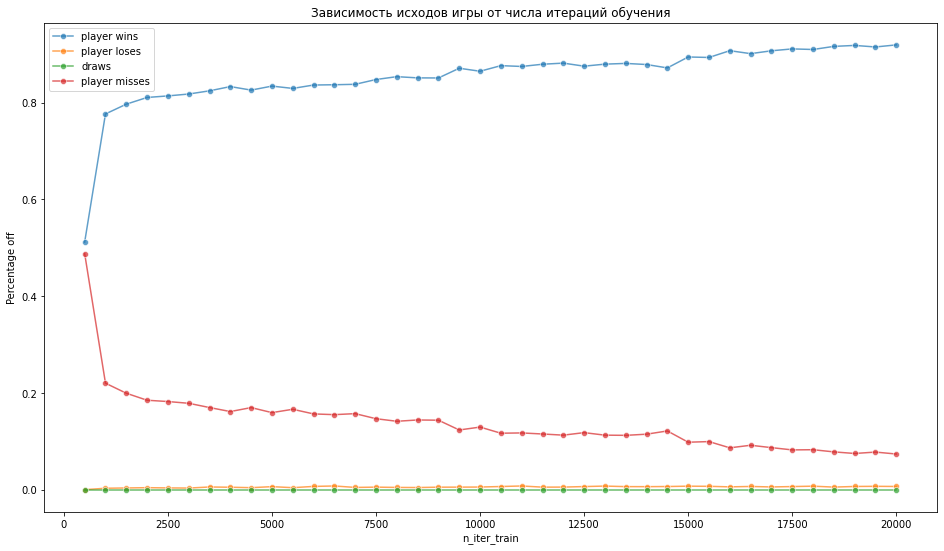

In [104]:
trainer.plot_learning_one('x', qplayer_x, rplayer_o, max_iter=20000, iter_step=500, iter_check=10000)

30 / 30 finished


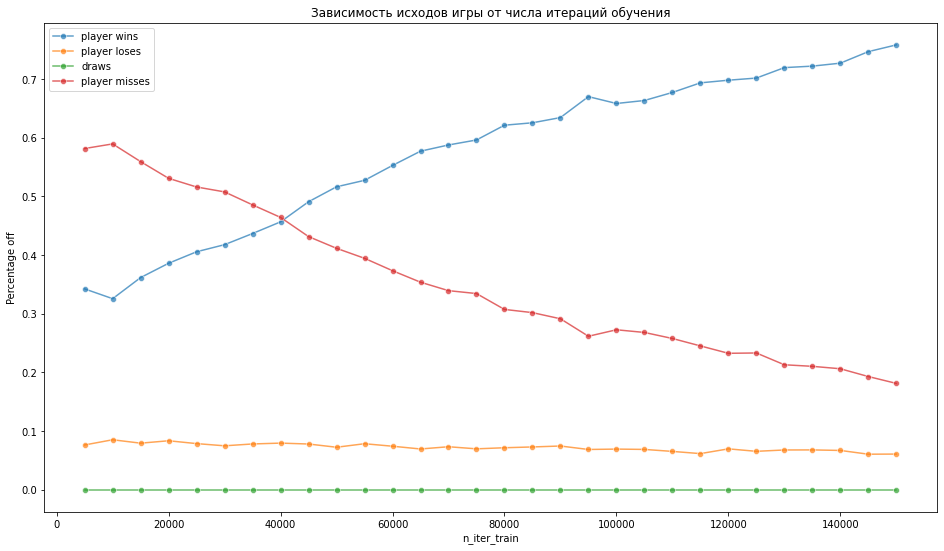

In [105]:
trainer.plot_learning_one('o', qplayer_o, rplayer_x, max_iter=150000, iter_step=5000, iter_check=20000)

## DQN

### 3x3

In [127]:
rplayer = RandomPlayer()
env = TicTacToe(3, 3)
game = TicTacToeGame(env)
trainer = Trainer(game)

In [309]:
model_x = torch.load('./dqn_player33_x_h128.pt')
model_o = torch.load('./dqn_player33_o_h128.pt')
player_x = DQNPlayer(eps=0.2, alpha=0.01, gamma=0.7, n_rows=3, n_cols=3, model=model_x)
player_o = DQNPlayer(0.2, 0.01, 0.7, 3, 3, model=model_o)

In [291]:
# trainer.train_deep('x', player_x, RandomPlayer(), batch_size=512, epochs=1500)

  0%|          | 0/1500 [00:00<?, ?it/s]

In [310]:
game.check_rewards(player_x, RandomPlayer())

  0%|          | 0/10000 [00:00<?, ?it/s]

{'wins_x': 9686, 'wins_o': 178, 'draws': 136, 'missx': 0, 'misso': 0}

In [300]:
# trainer.train_deep('o', player_o, RandomPlayer(), batch_size=512, epochs=1500)

  0%|          | 0/1500 [00:00<?, ?it/s]

In [311]:
game.check_rewards(RandomPlayer(), player_o)

  0%|          | 0/10000 [00:00<?, ?it/s]

{'wins_x': 1651, 'wins_o': 7135, 'draws': 1214, 'missx': 0, 'misso': 0}

In [312]:
game.check_rewards(player_x, player_o)

  0%|          | 0/10000 [00:00<?, ?it/s]

{'wins_x': 0, 'wins_o': 0, 'draws': 10000, 'missx': 0, 'misso': 0}